# 导入模块

In [1]:
from sklearn import tree
import sys
import os
import pandas as pd
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
pd.set_option("display.max_columns",None) #显示所有列
pd.set_option('display.max_rows', None)  #显示所有行
pd.set_option('display.width',2000) #设置显示宽度
plt.rcParams['font.sans-serif']=['Microsoft YaHei'] # 正常显示中文字体
plt.style.use('seaborn-notebook') #选择美化样式 ['bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'Solarize_Light2', 'tableau-colorblind10', '_classic_test']
sns.set_style({'font.sans-serif':['simhei','Arial']}) #设置字体风格
sns.set()#切换到seaborn的默认运行配置
from matplotlib.font_manager import FontProperties
myfont=FontProperties(fname=r'C:\Windows\Fonts\simhei.ttf',size=14)
sns.set(font=myfont.get_name())

# 数据预处理

In [2]:
rowdata=pd.read_csv("data.csv",encoding='gbk')
data=rowdata.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   岗位关键字   149 non-null    object
 1   岗位诱惑    149 non-null    object
 2   岗位名     149 non-null    object
 3   城市区域    149 non-null    object
 4   一般要求    149 non-null    object
 5   薪资水平    149 non-null    object
 6   公司名     149 non-null    object
 7   公司信息    149 non-null    object
dtypes: object(8)
memory usage: 9.4+ KB


分析:数据导入之后一共有8列属性，但是某些属性粒度切割不够细（例如：公司信息包含公司类型、融资阶段、规模等三个子信息；一般要求中又包括薪资、经验与学历），因此需要对数据进行进一步处理，以便更好分析。

In [3]:
data["经验"]=data["一般要求"].str.split("/",expand=True)[0]
data["学历"]=data["一般要求"].str.split("/",expand=True)[1]
data["经验"]=data["一般要求"].str.split(" ",expand=True)[1]
data.drop("一般要求",axis=1,inplace=True)
data["城市"]=data["城市区域"].str.split("·",expand=True)[0]
data["区域"]=data["城市区域"].str.split("·",expand=True)[1]
data.drop("城市区域",axis=1,inplace=True)
data["最低工资(k)"]=data["薪资水平"].str.split("-",expand=True)[0]
data["最低工资(k)"]=data["最低工资(k)"].apply(lambda x:int(x.replace("k","")))
data["最高工资(k)"]=data["薪资水平"].str.split("-",expand=True)[1]
data["最高工资(k)"]=data["最高工资(k)"].apply(lambda x:int(x.replace("k","")))
data.drop("薪资水平",axis=1,inplace=True)
data["公司类型"]=data["公司信息"].str.split(" / ",expand=True)[0]
data["公司规模"]=data["公司信息"].str.split(" / ",expand=True)[2]
data["融资阶段"]=data["公司信息"].str.split(" / ",expand=True)[1]
data.drop("公司信息",axis=1,inplace=True)
data["经验"]=data["经验"].apply(lambda x:x.replace("经验",""))
data=data[["岗位名","岗位关键字","城市","区域","经验","学历","最高工资(k)","最低工资(k)","岗位诱惑"
           ,"公司名","公司类型","公司规模","融资阶段"]]
data.head()

,岗位名,岗位关键字,城市,区域,经验,学历,最高工资(k),最低工资(k),岗位诱惑,公司名,公司类型,公司规模,融资阶段
0,数据分析,SQL 数据库 数据运营,成都,高新区,1-3年,本科,10,8,“大厂 团队管理 上升快 环境nice”,快手,文娱丨内容,2000人以上,D轮及以上
1,数据分析师,数据分析,深圳,车公庙,1-3年,本科,15,11,"“五险一金,绩效奖金,带薪年假,员工旅游”",平安产险,金融,2000人以上,上市公司
2,数据分析师/数据科学家,数据分析 数据挖掘 算法,北京,中关村,3-5年,硕士,40,20,"“薪酬福利优,领导靠谱,成长空间”",商汤科技,人工智能,2000人以上,C轮
3,数据分析师,数据分析,北京,西二旗,不限,本科,40,20,“高薪福利；行业独角兽；”,快手,文娱丨内容,2000人以上,D轮及以上
4,数据分析师（业务分析）-【商业化】,数据分析,北京,西二旗,3-5年,本科,40,20,“扁平化管理”,快手,文娱丨内容,2000人以上,D轮及以上


# 城市分析

    城市  岗位需求量
0   北京     58
1   上海     25
2   广州     21
3   深圳     18
4   杭州      7
5   成都      4
6   苏州      3
7   合肥      3
8   南京      2
9   天津      2
10  济南      1
11  武汉      1
12  重庆      1
13  厦门      1
14  长沙      1
15  青岛      1


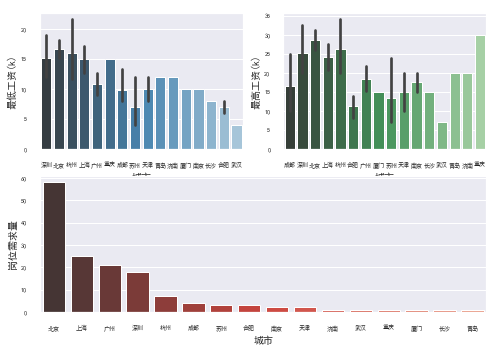

In [4]:
#绘制非对称子图
fig1=plt.figure() #设置图窗口
ax1=plt.subplot2grid((2,2),(0,0)) #设置第一张子图，位置0,0
ax2=plt.subplot2grid((2,2),(0,1))  #设置第二张子图，位置0,1
ax3=plt.subplot2grid((2,2),(1,0),colspan=2)  #设置第三张子图，位置1,0开始，列跨度为2
#plt.subplots_adjust(wspace=0.1, hspace=0.2)  # 调整子图间距

sns.barplot(x='城市', y='最低工资(k)', palette="Blues_d", data=data.sort_values("最低工资(k)",ascending=False), ax=ax1)
ax1.tick_params(axis='x',labelsize=6)
ax1.tick_params(axis='y',labelsize=6)
ax1.set_xlabel('城市',fontsize=10)
ax1.set_ylabel('最低工资(k)',fontsize=10)

sns.barplot(x='城市', y='最高工资(k)', palette="Greens_d", data=data, ax=ax2)
ax2.tick_params(axis='x',labelsize=6)
ax2.tick_params(axis='y',labelsize=6)
ax2.set_xlabel('城市',fontsize=10)
ax2.set_ylabel('最高工资(k)',fontsize=10)

data_city=data["城市"].value_counts().sort_values(ascending=False).to_frame().reset_index()
data_city.rename(columns=({'城市':'岗位需求量','index':'城市'}),inplace=True)
print(data_city)
# sns.countplot(data['城市'], palette="Reds_d", ax=ax3)
sns.barplot(x=data_city["城市"],y=data_city["岗位需求量"],palette="Reds_d", data=data_city, ax=ax3)#
ax3.tick_params(axis='x',labelsize=6)
ax3.tick_params(axis='y',labelsize=6)
ax3.set_xlabel('城市',fontsize=10)
ax3.set_ylabel('岗位需求量',fontsize=10)
plt.show()

In [30]:
value=[['北京', 58],
 ['上海', 25],
 ['广东', 39],
 ['浙江', 7],
 ['四川', 4],
 ['江苏', 5],
 ['安徽', 3],
 ['天津', 2],
 ['河北', 1],
 ['湖北', 1],
 ['重庆', 1],
 ['福建', 1],
 ['湖南', 1],
 ['山东', 1]]

In [31]:
from pyecharts.globals import CurrentConfig, NotebookType
CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_LAB
from pyecharts import options as opts
from pyecharts.charts import Map
from pyecharts.faker import Faker

c = (
    Map()
    .add("city", value, "china")
    .set_global_opts(
        title_opts=opts.TitleOpts(title="Map-China"), visualmap_opts=opts.VisualMapOpts(max_=58, is_piecewise=True)
    )

)
c.load_javascript()

In [32]:
c.render_notebook()

分析：从岗位需求来看，“北上广深杭”等互联网大城市对数据分析师需求最为旺盛，从地区分布来看，主要集中在长三角、珠三角、北京、成都等经济发达地区；从薪资来看，薪资水平与当地需求量呈正相关关系，其中杭州的最低工资差异较大，竞争较为激烈而北京的最低工资、最高工资均高于其他城市，且其祈福不大，说明市场较为稳定。

# 学历与经验分析

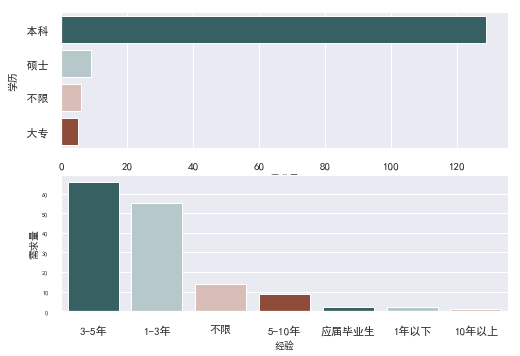

         需求比例
学历           
 本科  0.865772
 硕士  0.060403
 不限  0.040268
 大专  0.033557


In [33]:
mypal=sns.diverging_palette(200, 20, l=40, n=4)
fig2=plt.figure() #设置图窗口
ax1=plt.subplot2grid((2,1),(0,0))
ax2=plt.subplot2grid((2,1),(1,0))
# ax3=plt.subplot2grid((2,2),(1,0))
# ax4=plt.subplot2grid((2,2),(1,1))
plt.subplots_adjust(wspace=0.1, hspace=0.2)  # 调整子图间距
df_aca=data.groupby("学历")["区域"].count().sort_values(ascending=False).to_frame().reset_index()
sns.barplot(y="学历",x="区域",data=df_aca.head(20),ax=ax1,orient="h",palette=mypal)
ax1.set_xlabel("需求量",fontsize=10)
ax1.set_ylabel("学历",fontsize=10)
df_exp=data.groupby("经验")["区域"].count().sort_values(ascending=False).to_frame().reset_index()
sns.barplot(x='经验', y='区域', palette=mypal, data=df_exp, ax=ax2)
ax2.tick_params(axis='y',labelsize=6)
ax2.set_xlabel('经验',fontsize=10)
ax2.set_ylabel('需求量',fontsize=10)
plt.show()

df_aca2=pd.DataFrame()
df_aca2["需求比例"]=df_aca["区域"]/sum(df_aca["区域"])
df_aca2.index=df_aca["学历"]
print(df_aca2)

分析：目前数据分析岗位对于学历的要求绝大多数要求“本科以上”而其次是“硕士以上”，可见这一岗位专业性较强，对于学历存在一定门槛；从经验上来看，市场主要需求集中在“3~5”以及“1~3”年的职场人士，在这个经验层内相对掌握的业务知识和技术比较扎实，适用性最强，而“一年以下”（含应届毕业生）的需求很少，说明数据分析岗位十分看重求职者的工作经验，因此对于应届毕业生应该多多实习，积攒经验。

# 薪资分析

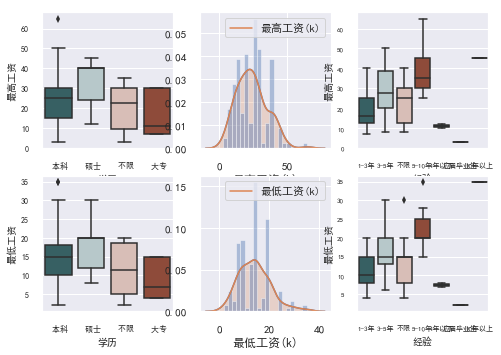

In [34]:
fig3,[[ax1,ax2,ax3],[ax4,ax5,ax6]]=plt.subplots(2,3)
sns.boxplot(x='学历', y='最高工资(k)', data=data, ax=ax1,palette=mypal)
ax1.tick_params(axis='x',labelsize=8)
ax1.tick_params(axis='y',labelsize=8)
ax1.set_xlabel('学历',fontsize=10)
ax1.set_ylabel('最高工资',fontsize=10)
sns.distplot(data["最高工资(k)"],ax=ax2,bins=20) #面积分布情况（直方图 ）
sns.kdeplot(data["最高工资(k)"],shade=True,ax=ax2)#生成核密度图
sns.boxplot(x='学历', y='最低工资(k)', data=data, ax=ax4,palette=mypal)
ax4.tick_params(axis='x',labelsize=8)
ax4.tick_params(axis='y',labelsize=8)
ax4.set_xlabel('学历',fontsize=10)
ax4.set_ylabel('最低工资',fontsize=10)

sns.distplot(data["最低工资(k)"],ax=ax5,bins=20) #面积分布情况（直方图 ）
sns.kdeplot(data["最低工资(k)"],shade=True,ax=ax5)#生成核密度图

sns.boxplot(x='经验', y='最高工资(k)', data=data, ax=ax3,palette=mypal)
ax3.tick_params(axis='x',labelsize=7)
ax3.tick_params(axis='y',labelsize=7)
ax3.set_xlabel('经验',fontsize=10)
ax3.set_ylabel('最高工资',fontsize=10)

sns.boxplot(x='经验', y='最低工资(k)', data=data, ax=ax6,palette=mypal)
ax6.tick_params(axis='x',labelsize=7)
ax6.tick_params(axis='y',labelsize=7)
ax6.set_xlabel('经验',fontsize=10)
ax6.set_ylabel('最低工资',fontsize=10)
plt.show()

分析：从统计结果来看，最高工资与最低工资的均值分别为24.26k以及14.31k，最高工资的集中度较高，集中在2030k之间，而最低工资则相对分散，10、15、20k三个位置较多，薪资水平差异较大，说明薪资的多少不仅仅取决所在的行业背景，在很大程度上与求职者的经验、技能、学历、所在城市有显著关系。从学历来看，硕士的薪资水平（最大值、最小值、平均值）均高于本科学历；经验上来看，510年经验的薪水较高，综合来看，薪资水平随学历以及经验呈现正相关关系。

# 公司信息分析

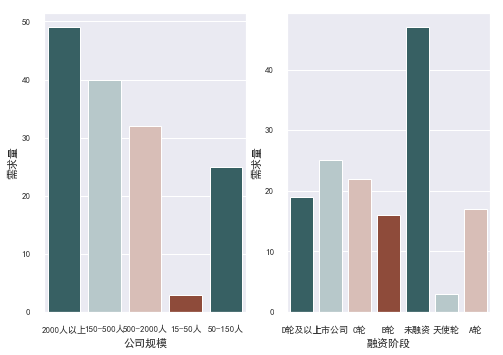

In [35]:
fig4,[ax1,ax2]=plt.subplots(1,2)
sns.countplot(data['公司规模'], palette=mypal, ax=ax1)
ax1.tick_params(axis='y',labelsize=9)
ax1.tick_params(axis='x',labelsize=9)
ax1.set_xlabel('公司规模',fontsize=11)
ax1.set_ylabel('需求量',fontsize=11)

data["融资阶段"]=data["融资阶段"].apply(lambda x:x.replace("不需要融资","未融资"))
sns.countplot(data['融资阶段'], palette=mypal, ax=ax2)
ax2.tick_params(axis='y',labelsize=9)
ax2.tick_params(axis='x',labelsize=9)
ax2.set_xlabel('融资阶段',fontsize=11)
ax2.set_ylabel('需求量',fontsize=11)

plt.show()

分析：从结果来看，大型公司以及融资末阶段、上市公司对数据分析的需求较大，说明数据分析岗在大公司的重视程度比较高，其前景看好。

# 相关性分析

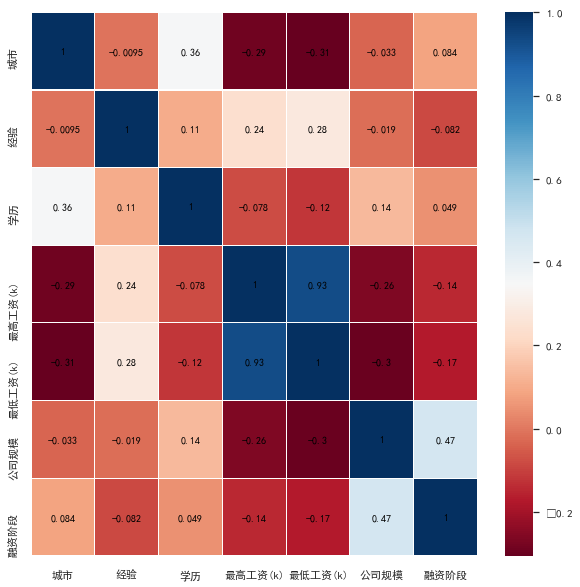

In [36]:
labels1 = data["城市"].unique().tolist()  # tolist()将数组array变为列表list
data["城市"] = data["城市"].apply(lambda x: labels1.index(x))
labels2 = data["经验"].unique().tolist()  # tolist()将数组array变为列表list
data["经验"] = data["经验"].apply(lambda x: labels2.index(x))
labels3 = data["学历"].unique().tolist()  # tolist()将数组array变为列表list
data["学历"] = data["学历"].apply(lambda x: labels3.index(x))
labels4 = data["公司规模"].unique().tolist()  # tolist()将数组array变为列表list
data["公司规模"] = data["公司规模"].apply(lambda x: labels4.index(x))
labels5= data["融资阶段"].unique().tolist()  # tolist()将数组array变为列表list
data["融资阶段"] = data["融资阶段"].apply(lambda x: labels5.index(x))
colormap = plt.cm.RdBu
plt.figure(figsize=(10,10))
# plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(data.corr(),linewidths=0.1,vmax=1.0, square=False,
            cmap=colormap, linecolor='white', annot=True,annot_kws={'size':10,'color':'black'})
plt.show()

分析：从相关性来看，公司融资阶段与公司规模相关、最高工资与城市、公司规模以及个人经验相关性更大而与学历的相关程度并不高，因此一个人工资上限并不被学历出身所束缚，但最低工资与学历的相关程度远大于最高工资与学历的相关程度，因此学历在很大程度上能够决定求职者薪资的下限。

# 总结

本文从数据分析的视角分析了当前市场上对于“数据分析”的需求情况，得到如下结论：
* 地域需求方面，岗位需求主要集中在经济发达地区（长三角、珠三角以及北京），在城市上集中于互联网大城市“北上广深杭”，其中北京市场相对成熟，杭州可变性较大；
* 岗位要求方面，集中在“本科以上学历”，“1~3”年工作经验，技能上主要以Sql等数据分析技能为主，同时补充一些“电商、生活消费、金融”等领域的业务知识，对于应届毕生生而言需求较少，竞争压力更大，因此在校生应该修炼基础技能、拓广业务知识、多实习积攒经验提高竞争力；
* 薪资方面，工资与城市、公司规模以及个人经验相关性大，且呈正相关关系；学历在很大程度能够决定求职者薪资的下限而不决定上限。